Check a test for Cape St Marys

In [1]:
import datetime
import glob
import os

import cartopy.geodesic as cgeodesic
import cartopy.crs as ccrs
from geopy.distance import distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import xarray as xr



In [2]:
colonies = {'CapeStMarys': [46.83, -54.2]}
LON_MIN=-57
LON_MAX=-52.5
LAT_MIN=45
LAT_MAX=48
lat, lon = colonies['CapeStMarys']


# Parameters to define foraging distance circle
radius_in_meters=74400



In [3]:
data_dir='/home/soontiensn/data/gpsc-work2/OPP/AvianFluProject/DriftCircle/CapeStMarys/test/runs/ciops-e_od_2022061500_P1D/'

files = glob.glob(os.path.join(data_dir, '*.nc'))
files.sort()

In [4]:
plot_proj = ccrs.Miller()
data_proj = ccrs.PlateCarree()

In [5]:
d = xr.open_dataset(files[0])
dnew = d.where(d.moving==1, drop=True)
dnew.lon

<xarray.DataArray 'lon' (ntraj: 781, time: 25)>
array([[-54.2     , -54.216286, -54.22747 , ..., -54.31306 , -54.322292,
        -54.330975],
       [-54.199608, -54.215633, -54.226704, ..., -54.31253 , -54.32181 ,
        -54.33054 ],
       [-54.19809 , -54.214554, -54.22584 , ..., -54.31027 , -54.319626,
        -54.328465],
       ...,
       [-53.798523, -53.811832, -53.82514 , ..., -54.050213, -54.064354,
        -54.079437],
       [-55.30234 , -55.316795, -55.329437, ..., -55.429325, -55.422985,
        -55.415764],
       [-54.543644, -54.55918 , -54.574314, ..., -54.702118, -54.70202 ,
        -54.698345]], dtype=float32)
Coordinates:
  * ntraj    (ntraj) int64 0 1 2 5 7 8 9 10 ... 988 989 990 991 993 995 998 999
  * time     (time) datetime64[ns] 2022-06-15 2022-06-15T01:00:00 ... 2022-06-16
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude
    minval:         -56.371243
    maxval:         -51.671535

In [6]:
def plot_map(myd):
  
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1, projection=plot_proj)
    ax.tissot(rad_km=radius_in_meters/1000,lats=lat,lons=lon,facecolor='none', edgecolor='gray')
    ax.set_extent([LON_MIN,LON_MAX,LAT_MIN,LAT_MAX])
    ax.coastlines()
    gl = ax.gridlines(draw_labels=['bottom', 'left'])

    #plot colony
    ax.plot(lon,lat, '*',ms=10, transform=data_proj)

    #plot starts
    #mesh = ax.scatter(myd.mod_lon.values[:,0], myd.mod_lat.values[:,0], marker='o', c=myd.distance_from_colony.values, 
    #                  transform=data_proj, cmap='copper')
    ax.plot(myd.lon.values[:,0], myd.lat.values[:,0],'oC2',ms=3, transform=data_proj)
    # plot stops
    #mesh = ax.scatter(myd.mod_lon.values[:,-1], myd.mod_lat.values[:,-1],marker='s', c=myd.distance_from_colony.values, 
    #                  transform=data_proj, cmap='copper')
    #cbar = plt.colorbar(mesh, ax=ax)
    ax.plot(myd.lon.values[:,-1], myd.lat.values[:,-1],'oC3',ms=3,transform=data_proj)


    #plot tracks
    num_runs = myd.ntraj.size
    for i in range(num_runs):
        ax.plot(myd.lon.values[i,:], myd.lat.values[i,:], 'k-', lw=0.5,alpha=0.5, transform=data_proj)
    # Formatting for title/save string
    timedelta = myd.time.values[-1] - myd.time.values[0]
    timedelta = timedelta.astype(np.timedelta64(1,'D'))/np.timedelta64(1,'D')
    start=pd.to_datetime(myd.time.values[0])
    #model_des = '{} with {}% winds from {}'.format(myd.mod_ocean_model,
                                                  # myd.mod_alpha_wind, 
                                                  # myd.mod_atmos_model)
    ax.set_title(myd.time[-1].values)
    return fig

In [7]:
def generate_maps(filename):
    # Open data
    d = xr.open_dataset(filename)
    # filter on land
    d = d.where(d.moving==1, drop=True)
    # filter data outside of foraging range
    initial_lon = d.lon.values[:,0]
    initial_lat = d.lat.values[:,0]
    distance_from_colony = np.empty(initial_lon.shape) 
    for i in range(distance_from_colony.size):
        distance_from_colony[i] = distance((lat,lon), (initial_lat[i], initial_lon[i])).km
    distance_from_colony = xr.DataArray(data=distance_from_colony, dims='ntraj')
    d['distance_from_colony'] = distance_from_colony
    dnew = d.where(distance_from_colony<radius_in_meters/1000,drop=True)
    
    # Set up save directory
#    run_save_dir='{}_{}_{}'.format(dnew.mod_ocean_model,
#                                   dnew.mod_atmos_model,
#                                   dnew.mod_alpha_wind)
#    if not os.path.exists(run_save_dir):
#        os.makedirs(run_save_dir)
    times = dnew.time.values
    start = times[0]
    end = times[-1]
    print(end)
    timesave = pd.to_datetime(start).strftime('%Y%m%d%H')
    
#    if not os.path.exists('{}/{}'.format(run_save_dir,timesave)):
#        os.makedirs('{}/{}'.format(run_save_dir,timesave))
    
    # Loop over times
    dplot = start
    while dplot <= end:
        dtime = dnew.where(dnew.time<=dplot ,drop=True)
        timedelta = dtime.time.values[-1] - dtime.time.values[0]
        timedelta = timedelta.astype(np.timedelta64(1,'D'))/np.timedelta64(1,'D')
        fig = plot_map(dtime)
#        fsave = '{}-{}_P{}D.png'.format(run_save_dir.lower(),
#                                    timesave,
#                                    str(int(timedelta)).zfill(3))
#        savename = os.path.join(run_save_dir,
#                                timesave,
  #                              fsave
  #                             )
#        print(savename)
#        fig.savefig(savename, bbox_inches='tight', transparent=False, dpi=300, facecolor='white')
        dplot = dplot + np.timedelta64(3, 'h')
    return fig

2022-06-16T00:00:00.000000000


/home/soontiensn/miniconda-new/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:845: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/home/soontiensn/miniconda-new/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soontiensn/miniconda-new/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated 

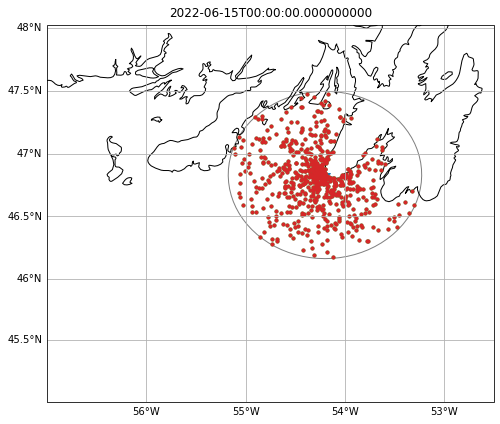

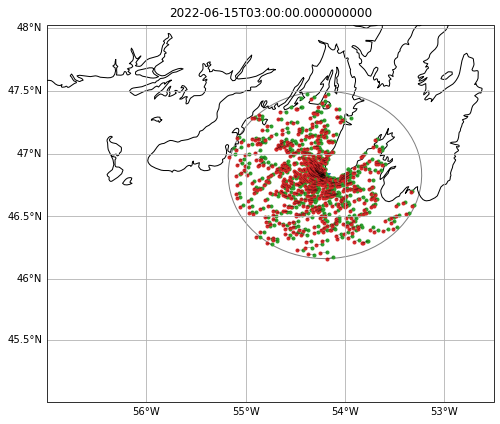

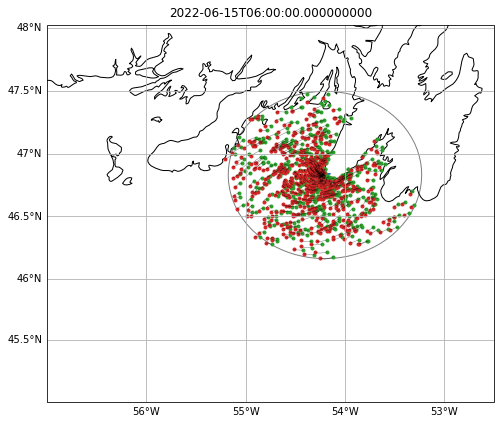

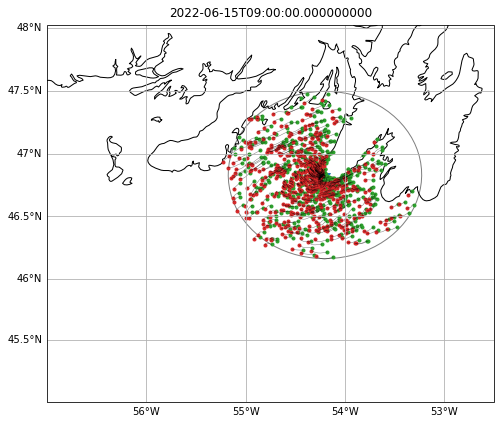

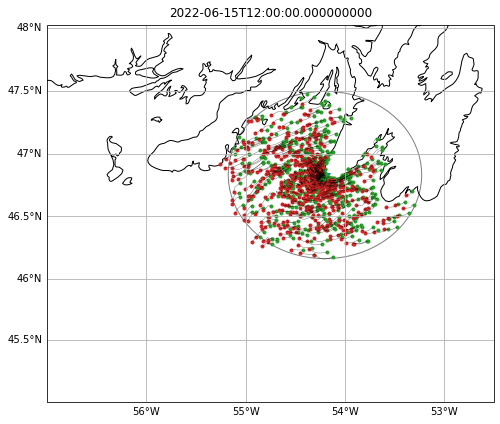

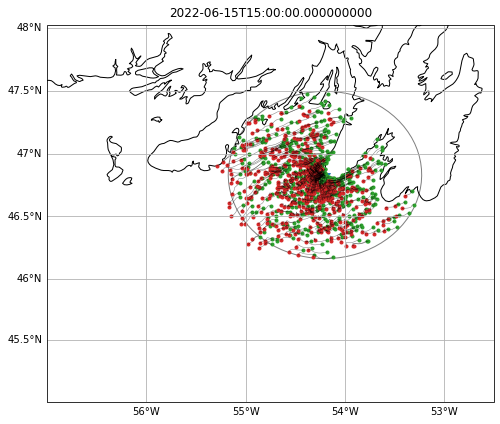

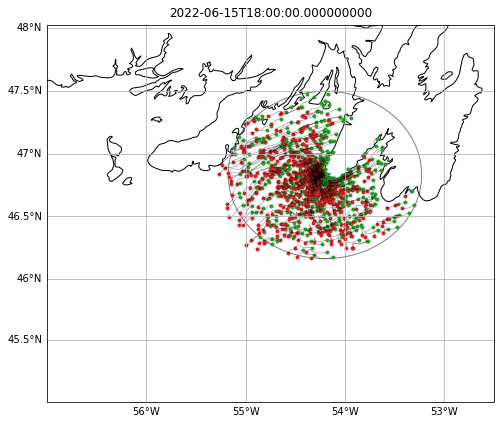

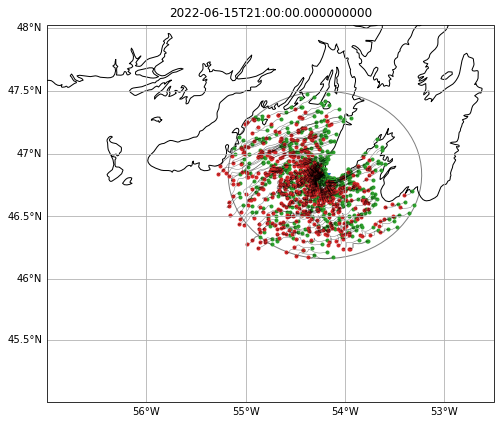

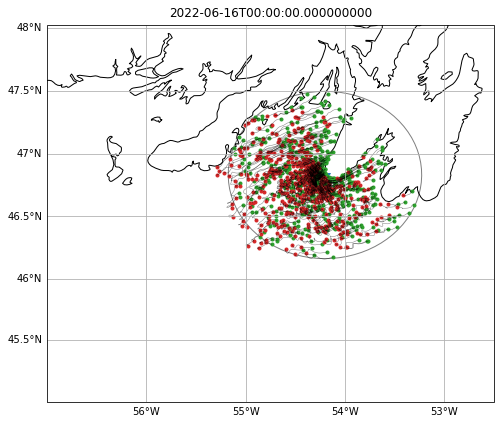

In [8]:
for file in files:
    fig = generate_maps(file)

In [9]:
d.moving

<xarray.DataArray 'moving' (ntraj: 1000, time: 25)>
array([[          1,           1,           1, ...,           1,           1,
                  1],
       [          1,           1,           1, ...,           1,           1,
                  1],
       [          1,           1,           1, ...,           1,           1,
                  1],
       ...,
       [          0, -2147483647, -2147483647, ..., -2147483647, -2147483647,
        -2147483647],
       [          1,           1,           1, ...,           1,           1,
                  1],
       [          1,           1,           1, ...,           1,           1,
                  1]], dtype=int32)
Coordinates:
  * ntraj    (ntraj) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) datetime64[ns] 2022-06-15 2022-06-15T01:00:00 ... 2022-06-16
Attributes:
    minval:   0
    maxval:   1

In [10]:
dnew = d.where(d.moving==1, drop=True)

In [11]:
dnew.lon

<xarray.DataArray 'lon' (ntraj: 781, time: 25)>
array([[-54.2     , -54.216286, -54.22747 , ..., -54.31306 , -54.322292,
        -54.330975],
       [-54.199608, -54.215633, -54.226704, ..., -54.31253 , -54.32181 ,
        -54.33054 ],
       [-54.19809 , -54.214554, -54.22584 , ..., -54.31027 , -54.319626,
        -54.328465],
       ...,
       [-53.798523, -53.811832, -53.82514 , ..., -54.050213, -54.064354,
        -54.079437],
       [-55.30234 , -55.316795, -55.329437, ..., -55.429325, -55.422985,
        -55.415764],
       [-54.543644, -54.55918 , -54.574314, ..., -54.702118, -54.70202 ,
        -54.698345]], dtype=float32)
Coordinates:
  * ntraj    (ntraj) int64 0 1 2 5 7 8 9 10 ... 988 989 990 991 993 995 998 999
  * time     (time) datetime64[ns] 2022-06-15 2022-06-15T01:00:00 ... 2022-06-16
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude
    minval:         -56.371243
    maxval:         -51.671535